# 1. 데이터 선정 이유 및 문제 정의
---
`문제` 
<br>온라인 교육에 적응하지 못하는 학생들이 있음 

-> 온라인 교육은 점점 확대되는 추세이기 때문에 학생의 적응을 도와야 함

<br>`목표` 
<br>1. 온라인 교육 적응도 예측 2. 온라인 교육 적응과 관련된 특성 파악

<br>`질문` 
<br>어떤 조건을 가진 학생들이 온라인 교육에 취약한 경향을 보일까?

(온라인 교육에 적응이 어려울 것으로 예측되는 학생들에게 필요한 지원을 해준다면 온라인 교육의 효용성을 높일 수 있지 않을까?)

# 2. 데이터 전처리, EDA, 시각화
---



In [ ]:
import sys
import xgboost
import warnings

if "google.colab" in sys.modules:
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.5 MB/s 
     |████████████████████████████████| 133 kB 54.9 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=1f68f142ed41cdebe3dcec341222e9379b1f1262116f0facf4a6f7b236199a20
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requir

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving students_adaptability_level_online_education.csv to students_adaptability_level_online_education.csv


In [ ]:
import pandas as pd

df = pd.read_csv('students_adaptability_level_online_education.csv')
df.head(10)

,Education Level,Institution Type,Gender,Age,Device,IT Student,Location,Financial Condition,Internet Type,Network Type,Flexibility Level
0,University,Private,Male,23,Tab,No,Town,Mid,Wifi,4G,Moderate
1,University,Private,Female,23,Mobile,No,Town,Mid,Mobile Data,4G,Moderate
2,College,Public,Female,18,Mobile,No,Town,Mid,Wifi,4G,Moderate
3,School,Private,Female,11,Mobile,No,Town,Mid,Mobile Data,4G,Moderate
4,School,Private,Female,18,Mobile,No,Town,Poor,Mobile Data,3G,Low
5,School,Private,Male,11,Mobile,No,Town,Poor,Mobile Data,3G,Low
6,School,Private,Male,11,Mobile,No,Town,Mid,Wifi,4G,Low
7,School,Private,Male,11,Mobile,No,Town,Mid,Wifi,4G,Moderate
8,College,Public,Male,18,Mobile,No,Town,Mid,Wifi,4G,Low
9,School,Private,Male,11,Mobile,No,Town,Mid,Mobile Data,3G,Moderate


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education Level      1205 non-null   object
 1   Institution Type     1205 non-null   object
 2   Gender               1205 non-null   object
 3   Age                  1205 non-null   int64 
 4   Device               1205 non-null   object
 5   IT Student           1205 non-null   object
 6   Location             1205 non-null   object
 7   Financial Condition  1205 non-null   object
 8   Internet Type        1205 non-null   object
 9   Network Type         1205 non-null   object
 10  Flexibility Level    1205 non-null   object
dtypes: int64(1), object(10)
memory usage: 103.7+ KB


In [ ]:
df.duplicated().sum()
# 중복 데이터를 제거하면 데이터 크기가 너무 작아져서 제거하지 않고 진행

980

In [ ]:
df.isnull().sum()

Education Level        0
Institution Type       0
Gender                 0
Age                    0
Device                 0
IT Student             0
Location               0
Financial Condition    0
Internet Type          0
Network Type           0
Flexibility Level      0
Effectiveness          0
dtype: int64

In [ ]:
for col in df:
  print(df[col].unique())

['University' 'College' 'School']
['Private' 'Public']
['Male' 'Female']
[23 18 11 27 10  9]
['Tab' 'Mobile' 'Computer']
['No' 'Yes']
['Town' 'Rural']
['Mid' 'Poor' 'Rich']
['Wifi' 'Mobile Data']
['4G' '3G' '2G']
['Moderate' 'Low' 'High']
[ True False]


### a. 타겟 특성 분포 확인 후 이진분류문제로 변환

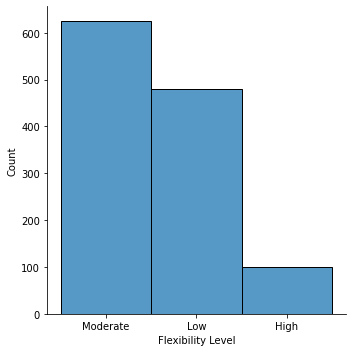

In [ ]:
# 타겟 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df['Flexibility Level']);

In [ ]:
# Effectiveness 특성을 만들어 이진분류문제로 변환
df['Effectiveness'] = df['Flexibility Level'] != 'Low'
df['Effectiveness'].nunique()

2

In [ ]:
df['Effectiveness'].value_counts()

True     725
False    480
Name: Effectiveness, dtype: int64

In [ ]:
df.head(10)

,Education Level,Institution Type,Gender,Age,Device,IT Student,Location,Financial Condition,Internet Type,Network Type,Flexibility Level,Effectiveness
0,University,Private,Male,23,Tab,No,Town,Mid,Wifi,4G,Moderate,True
1,University,Private,Female,23,Mobile,No,Town,Mid,Mobile Data,4G,Moderate,True
2,College,Public,Female,18,Mobile,No,Town,Mid,Wifi,4G,Moderate,True
3,School,Private,Female,11,Mobile,No,Town,Mid,Mobile Data,4G,Moderate,True
4,School,Private,Female,18,Mobile,No,Town,Poor,Mobile Data,3G,Low,False
5,School,Private,Male,11,Mobile,No,Town,Poor,Mobile Data,3G,Low,False
6,School,Private,Male,11,Mobile,No,Town,Mid,Wifi,4G,Low,False
7,School,Private,Male,11,Mobile,No,Town,Mid,Wifi,4G,Moderate,True
8,College,Public,Male,18,Mobile,No,Town,Mid,Wifi,4G,Low,False
9,School,Private,Male,11,Mobile,No,Town,Mid,Mobile Data,3G,Moderate,True


### b. 새로운 타겟 특성의 비율

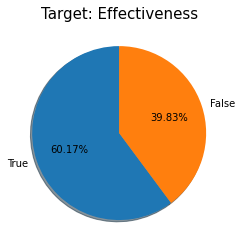

In [ ]:
import matplotlib.pyplot as plt

target = 'Effectiveness'

plt.pie(
    ((df[target] == True).sum(), (df[target] == False).sum()),
    labels=('True', 'False'),
    autopct="%.2f%%",
    shadow=True,
    startangle=90,
)
plt.title("Target: Effectiveness", size=15)
plt.show()

# 3. 모델링 및 모델 해석

---



In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=2)
train.shape, test.shape

((964, 12), (241, 12))

In [ ]:
def divide_data(df):

    target = 'Effectiveness'
    X = df.drop([target, 'Flexibility Level'], axis=1)
    y = df[target]

    return X, y

In [ ]:
X_train, y_train = divide_data(train)
X_test, y_test = divide_data(test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(964, 10) (964,) (241, 10) (241,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier

def fit(X_train, y_train):
    pipeline = make_pipeline(
      OrdinalEncoder(),
      XGBClassifier(n_estimators=200
                    , random_state=2
                    , n_jobs=-1
                    , max_depth=7
                    , learning_rate=0.2
                  )
    )   

    dists = {
        'xgbclassifier__max_depth' : [3, 4, 5, 6, 8, 10, 12, 15],
        'xgbclassifier__learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'xgbclassifier__min_child_weight' : [1, 3, 5, 7],
        'xgbclassifier__gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
        'xgbclassifier__colsample_bytree' : [0.3, 0.4, 0.5, 0.7]
    }

    clf = RandomizedSearchCV(
      pipeline, 
      param_distributions=dists,
      n_iter=5, 
      cv=3, 
      scoring='roc_auc',
      verbose=1,  
      n_jobs=-1,
      random_state = 42
    )
    
    clf.fit(X_train, y_train)
    print("Optimal Hyperparameter:", clf.best_params_)
    print("AUC:", clf.best_score_)

    return clf

def predict(X, y, best_estimator):

    clf = fit(X, y)
    clf.best_estimator_ = best_estimator
    y_pred_proba = clf.predict_proba(X)[:, 1]

    report = classification_report(y, y_pred_proba > 0.5)
    return y_pred_proba, report

In [ ]:
clf = fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Optimal Hyperparameter: {'xgbclassifier__min_child_weight': 5, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.7}
AUC: 0.8868806834948231


### a. 기준모델과 성능비교

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Optimal Hyperparameter: {'xgbclassifier__min_child_weight': 5, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__gamma': 0.0, 'xgbclassifier__colsample_bytree': 0.4}
AUC: 0.7567356055010376
              precision    recall  f1-score   support

       False       0.76      0.76      0.76        79
        True       0.88      0.88      0.88       162

    accuracy                           0.84       241
   macro avg       0.82      0.82      0.82       241
weighted avg       0.84      0.84      0.84       241



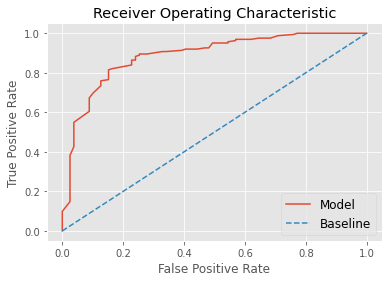

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(y, y_pred_proba):
    auc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("Receiver Operating Characteristic")
    plt.legend(prop={"size": 12})
    plt.show()
    return auc_score

y_test_pred_proba, report = predict(X_test, y_test, clf.best_estimator_)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)

In [ ]:
print("Test AUC:", auc_score)

Test AUC: 0.8866229098296609


In [ ]:
pipeline = clf.best_estimator_

encoder = pipeline.named_steps['ordinalencoder']
model = pipeline.named_steps['xgbclassifier']
X_test_encoded =  encoder.transform(X_test)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

def get_permutation_importance(X, y, model):
    permuter = PermutationImportance(
        model,
        scoring='roc_auc',
        n_iter=5, 
        random_state=42)
    permuter.fit(X, y)

    return permuter

In [ ]:
permuter = get_permutation_importance(X_test_encoded, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test.columns.tolist())

Weight,Feature
0.1607 ± 0.0159,Institution Type
0.1054 ± 0.0230,Age
0.0953 ± 0.0124,Gender
0.0861 ± 0.0297,Network Type
0.0852 ± 0.0144,Education Level
0.0774 ± 0.0488,IT Student
0.0713 ± 0.0334,Financial Condition
0.0576 ± 0.0284,Internet Type
0.0507 ± 0.0182,Location
0.0321 ± 0.0085,Device


In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

def get_pdp_isolated(dataset, model, feature):
    pdp_isolated = pdp_isolate(
      model=model, 
      dataset=dataset, 
      model_features=dataset.columns, 
      feature=feature,
      grid_type='percentile', # default='percentile', or 'equal'
      num_grid_points=10 # default=10
    )

    return pdp_isolated

In [ ]:
X_test_preprocessed_df = pd.DataFrame(X_test_encoded, columns=X_test.columns)
feature = 'Institution Type'
pdp_isolated = get_pdp_isolated(X_test_preprocessed_df, model, feature)

for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

### b. 특성 중요도

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


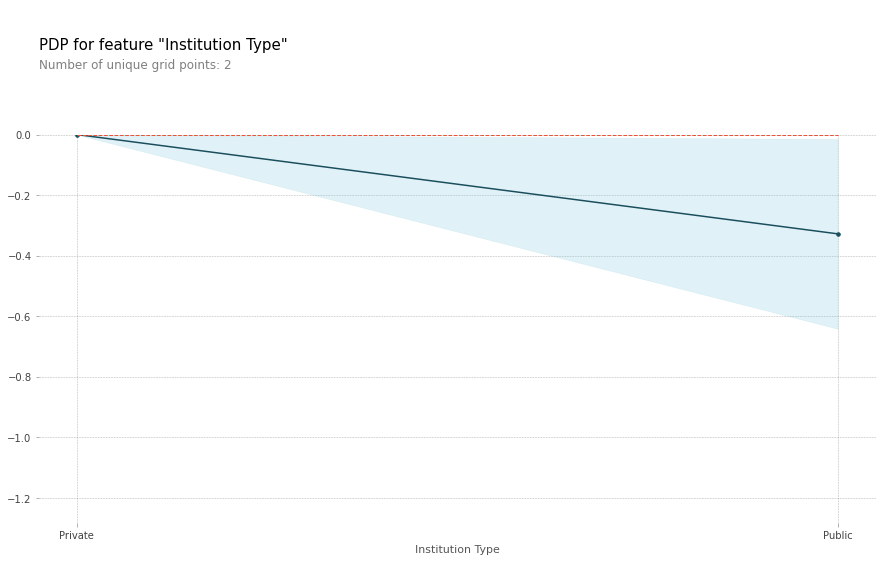

In [ ]:
pdp_plot(pdp_isolated, feature_name=feature);
plt.xticks(category_codes, category_names);

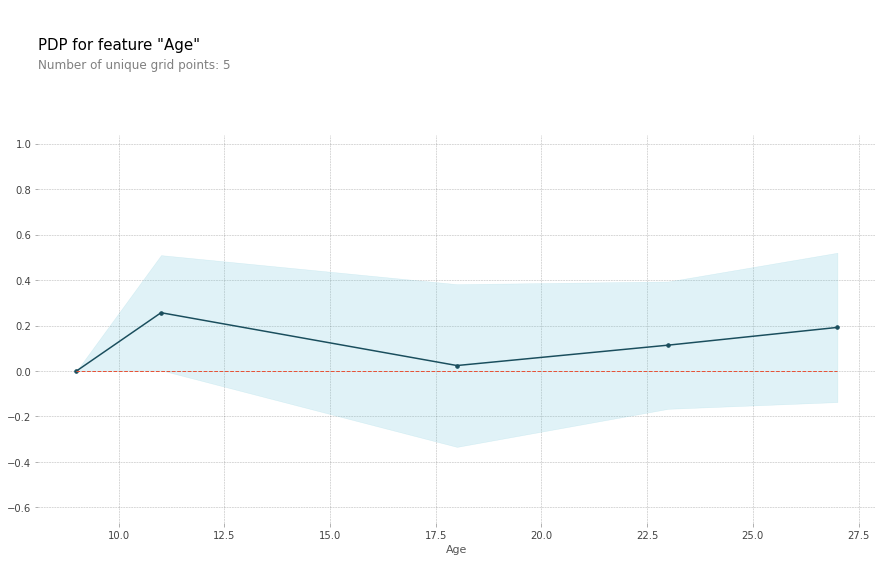

In [ ]:
feature = 'Age'
pdp_isolated = get_pdp_isolated(X_test_preprocessed_df, model, feature) 
pdp_plot(pdp_isolated, feature_name=feature);

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

def get_pdp_interaction(dataset, model, features):
    pdp_interaction = pdp_interact(
        model=model, 
        dataset=dataset,
        model_features=dataset.columns, 
        features=features
    )

    return pdp_interaction

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


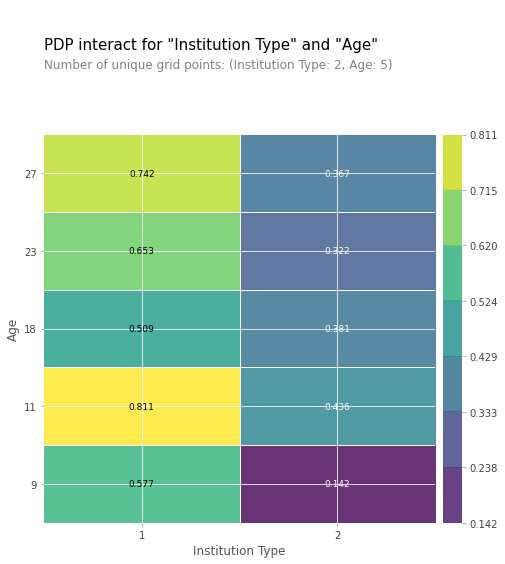

In [ ]:
features = ['Institution Type', 'Age']
pdp_interaction = get_pdp_interaction(X_test_preprocessed_df, model, features)
pdp_interact_plot(pdp_interaction, feature_names=features, plot_type="grid");

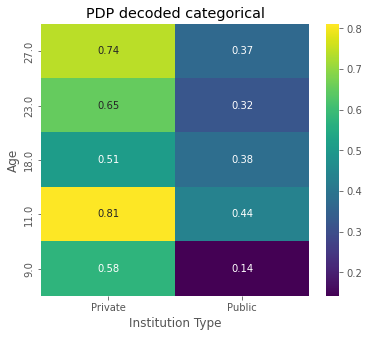

In [ ]:
pdp = pdp_interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(6,5))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('PDP decoded categorical');

# 4. 결론 및 후기


---
- 교육기관이 공립/사립 여부가 학생의 온라인 교육 적응에 가장 큰 영향
- 공립 교육기관 학생들의 온라인 교육 적응을 지원하면 전체적인 온라인 교육 효용성을 높일 수 있을 것이라 기대
- 데이터셋의 크기가 작고 데이터 값의 분포가 다양하지 않은 점이 아쉬웠음